The Objective of this notebook is to z score normalise time series stock data (accounting for look forward errors etc.)
Resources:
- https://github.com/Auquan/Tutorials/blob/master/Pairs%20Trading.ipynb
- https://quantpy.com.au/python-for-finance/plotting-stock-market-data/
- https://www.econstor.eu/bitstream/10419/116783/1/833997289.pdf


In [213]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected=True)

pd.options.plotting.backend = 'plotly'

In [214]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    return stockData

In [215]:
#fixing error
import yfinance as yfin
yfin.pdr_override()

end = dt.datetime(2023, 1, 1)
start = dt.datetime(2006,1,1)

stocks = ['BHP', 'RIO', 'NCM', 'JHX']
stocksax = [stock + '.AX' for stock in stocks]

data = get_data(stocksax, start, end)
data.isna().sum()

[*********************100%***********************]  4 of 4 completed


BHP.AX    0
JHX.AX    0
NCM.AX    0
RIO.AX    0
dtype: int64

In [31]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

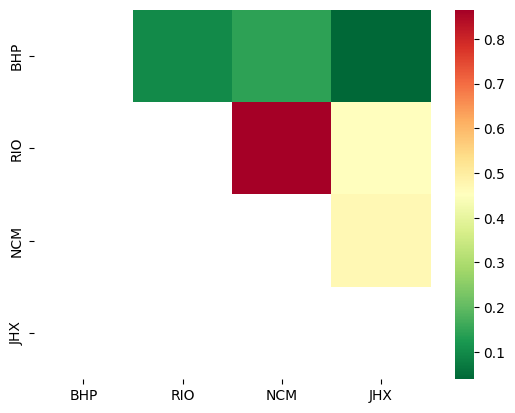

[('BHP.AX', 'RIO.AX')]


In [234]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
pairs=[]
scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=stocks, 
                yticklabels=stocks, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print(pairs)

Looks like BHP and RIO are cointegrated

In [217]:
ratio = pd.DataFrame()
ratio['Ratio'] = data["RIO.AX"]/data["BHP.AX"]
ratio.head()

,Ratio
Date,
2006-01-03,2.545210
2006-01-04,2.514761
2006-01-05,2.496337
2006-01-06,2.486917
2006-01-09,2.461941


In [73]:
w = 200
ratio[f'MA{w}'] = ratio['Ratio'].rolling(window=w, min_periods=0).mean()
ratio[f'MD{w}'] = ratio['Ratio'].rolling(window=w, min_periods=0).std()
ratio[f'Z{w}'] = (ratio['Ratio'] - ratio[f'MA{w}'])/ratio[f'MD{w}']
ratio.head()

,Ratio,MA200,MD200,Z200
Date,,,,
2006-01-03,2.545210,2.545210,NaN,NaN
2006-01-04,2.514761,2.529985,0.021531,-0.707107
2006-01-05,2.496337,2.518769,0.024682,-0.908855
2006-01-06,2.486917,2.510806,0.025686,-0.930043
2006-01-09,2.461941,2.501033,0.031183,-1.253644


In [83]:
# plotting the ratio
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=("Ratio"), row_width=[1])
# fig.add_trace(go.Scatter(x=data.index, y=data["BHP.AX"], marker_color='black',name="BHP", showlegend=True), row=1, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data["RIO.AX"], marker_color='yellow',name="RIO", showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=ratio['Ratio'], marker_color='black',name="ratio", showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=ratio['MA200'], marker_color='grey',name="MA200", showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=ratio['MD200'], marker_color='green',name="MD200", showlegend=True), row=1, col=1)

th = 2
# fig.add_hline(y=th, line_color="green")
# fig.add_hline(y=-th, line_color="red")
fig.update(layout_xaxis_rangeslider_visible=True)

fig.show()

In [99]:
buy = ratio['Z200'].copy()
sell = ratio['Z200'].copy()

buy[ratio['Z200']> -1] = 0
sell[ratio['Z200']<1] = 0
buy

Date
2006-01-03         NaN
2006-01-04    0.000000
2006-01-05    0.000000
2006-01-06    0.000000
2006-01-09   -1.253644
                ...   
2022-12-22    0.000000
2022-12-23    0.000000
2022-12-28    0.000000
2022-12-29    0.000000
2022-12-30    0.000000
Name: Z200, Length: 4299, dtype: float64

In [123]:
th = 1.5
# buy and sell markers
buy = ratio['Z200'].copy()
sell = ratio['Z200'].copy()

buy[ratio['Z200']> -th] = None
sell[ratio['Z200']< th] = None


# plotting the ratio
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=(""), row_width=[1])
# fig.add_trace(go.Scatter(x=data.index, y=data["BHP.AX"], marker_color='black',name="BHP", showlegend=True), row=1, col=1)
# fig.add_trace(go.Scatter(x=data.index, y=data["RIO.AX"], marker_color='yellow',name="RIO", showlegend=True), row=1, col=1)
fig.add_trace(go.Scatter(x=ratio.index, y=ratio['Z200'], marker_color='black',name="Z-normalised RIO:BHP Ratio", showlegend=True), row=1, col=1)
#fig.add_scatter(x=ratio.index, y=buy, marker_symbol='x', marker_size=20)
fig.add_trace(go.Scatter(x=ratio.index, y=buy, marker_symbol='x', marker_size=10, name="buy"))
fig.add_trace(go.Scatter(x=ratio.index, y=sell, marker_symbol='x', marker_size=10, name="sell"))

fig.add_hline(y=th, line_color="green")
fig.add_hline(y=-th, line_color="red")
fig.update(layout_xaxis_rangeslider_visible=True)

fig.update_layout(
    title=dict(text="Ratio between BHP and RIO", font=dict(size=30), automargin=True, yref='paper')
)
fig.show()

# Time to get the markers

In [233]:
clean_ratio, train, test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
clean_ratio['Ratio'] = data["RIO.AX"]/data["BHP.AX"]
# making the train test split
train_amount = int(round(len(clean_ratio)*0.7, 0))
test_amount = len(clean_ratio) - train_amount

train['Ratio'] = clean_ratio[:train_amount]
test['Ratio'] = clean_ratio[train_amount:]

# check the p value for the training test testing data
# training
tr_score, tr_pvalue, _ = coint(data["RIO.AX"][:train_amount], data["BHP.AX"][:train_amount])
te_score, te_pvalue, _ = coint(data["RIO.AX"][train_amount:], data["BHP.AX"][train_amount:])
o_score, o_pvalue, _ = coint(data["RIO.AX"], data["BHP.AX"])


print("Training p-value:",tr_pvalue)
print("Testing p-value:",te_pvalue)
print("Overall p-value:",o_pvalue)

Training p-value: 0.21591455334263432
Testing p-value: 0.00857811283470426
Overall p-value: 0.2076886028830307


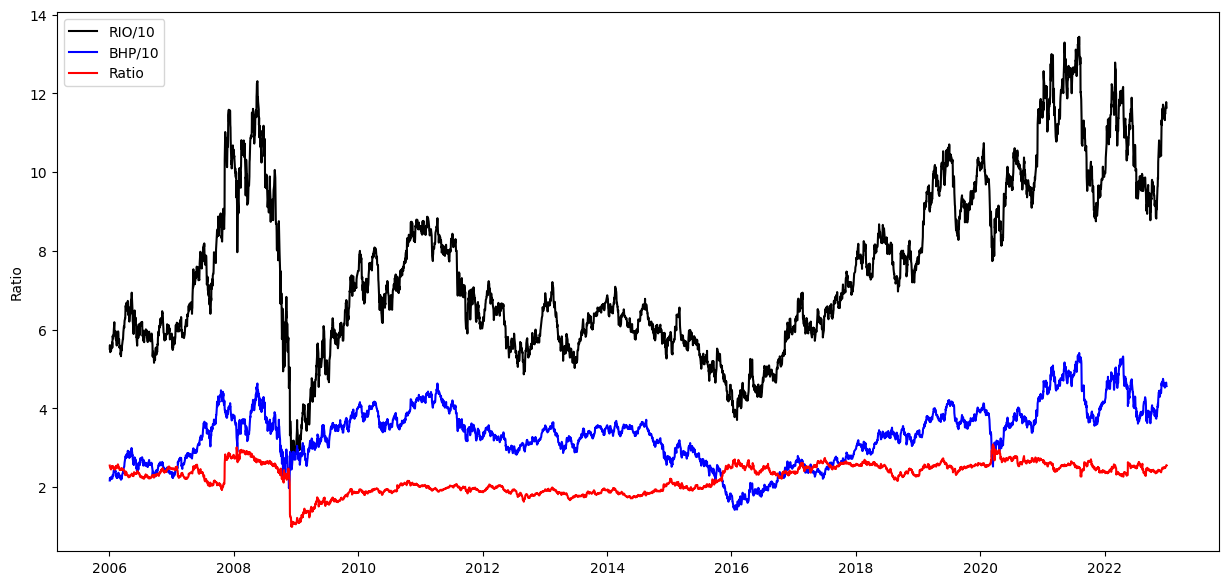

In [229]:
# Plot all stocks with the ratio
plt.figure(figsize=(15,7))
plt.plot(data.index, data["RIO.AX"]/10, color='black')
plt.plot(data.index, data["BHP.AX"]/10, color='blue')
plt.plot(data.index, clean_ratio, color='red')
# plt.plot(train.index, train, color='green')
# plt.plot(test.index, test, color='red')

plt.legend(['RIO/10', 'BHP/10', 'Ratio'])

plt.ylabel('Ratio')
plt.show()

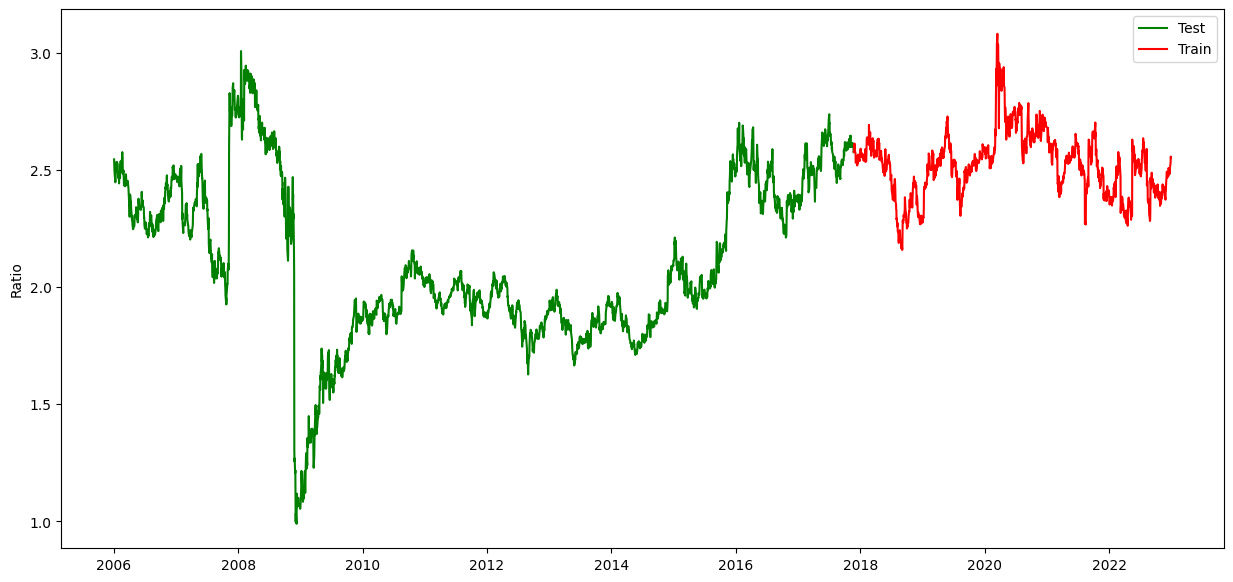

In [219]:
# visualise training and testing data
plt.figure(figsize=(15,7))
plt.plot(train.index, train, color='green')
plt.plot(test.index, test, color='red')

plt.legend(['Test','Train'])

plt.ylabel('Ratio')
plt.show()


In [220]:
def moving_data(data, window, std=False):
    # min periods is to prevent having no data at start
    ma = data.rolling(window=window, center=False).mean()
    if std:
        std = data.rolling(window=window, center=False).std()
        return ma, std
    return ma
train['Ratio']

Date
2006-01-03    2.545210
2006-01-04    2.514761
2006-01-05    2.496337
2006-01-06    2.486917
2006-01-09    2.461941
                ...   
2017-11-17    2.613938
2017-11-20    2.610620
2017-11-21    2.611091
2017-11-22    2.599638
2017-11-23    2.575465
Name: Ratio, Length: 3009, dtype: float64

In [221]:
# Visualising the training data
win_main = 30
win2 = 5
train[f'MA{win2}'] = moving_data(train['Ratio'], win2)
train[f'MA{win_main}'], train[f'MD{win_main}'] = moving_data(train['Ratio'], win_main, std=True)
train[f'MZ{win_main}'] = (train['Ratio'] - train[f'MA{win_main}'])/train[f'MD{win_main}']

train.head(5)

,Ratio,MA5,MA30,MD30,MZ30
Date,,,,,
2006-01-03,2.545210,NaN,NaN,NaN,NaN
2006-01-04,2.514761,NaN,NaN,NaN,NaN
2006-01-05,2.496337,NaN,NaN,NaN,NaN
2006-01-06,2.486917,NaN,NaN,NaN,NaN
2006-01-09,2.461941,2.501033,NaN,NaN,NaN


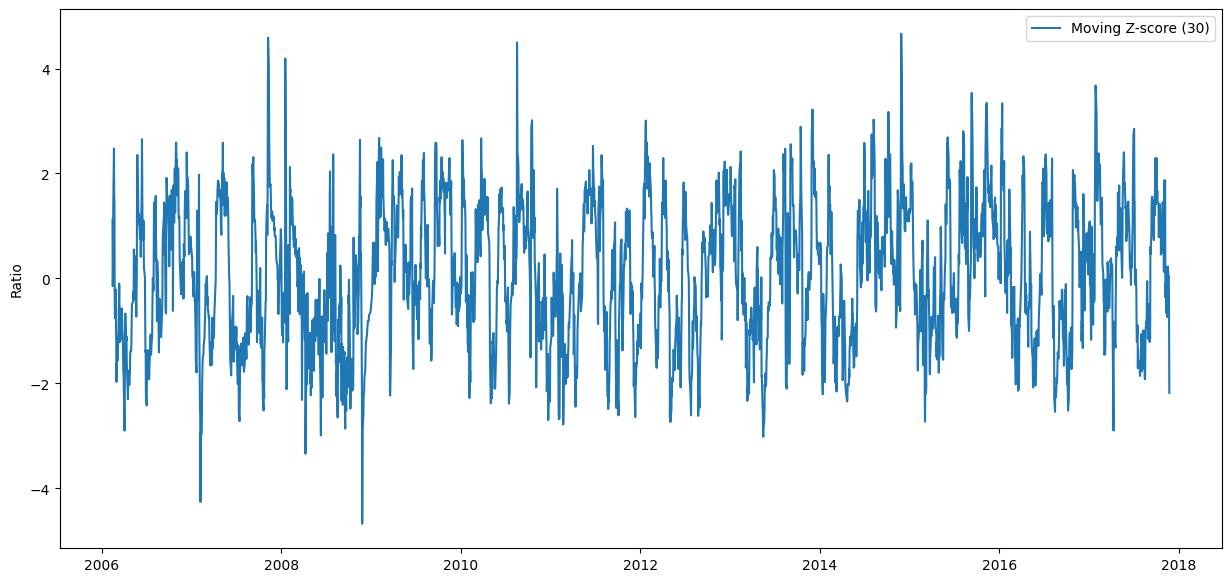

In [230]:
# plot the z score
plt.figure(figsize=(15,7))
plt.plot(train.index, train['MZ30'])

plt.legend(['Moving Z-score (30)'])
plt.ylabel('Ratio')
plt.show()

In [ ]:
#todo compare the 60d MZ with the 200d MZ
# add the 1.5 zscore lines
# add the markers following guide
# watch a video on pairs trading
# write up my own strategy on paper or sketch it like a flowchart
# write it up in code
# backtest

# follow the quantopian recommendations for future exploration and implementing the strategy (also graphing everything together)
# read the review paper to further understand ideas and countinually refine